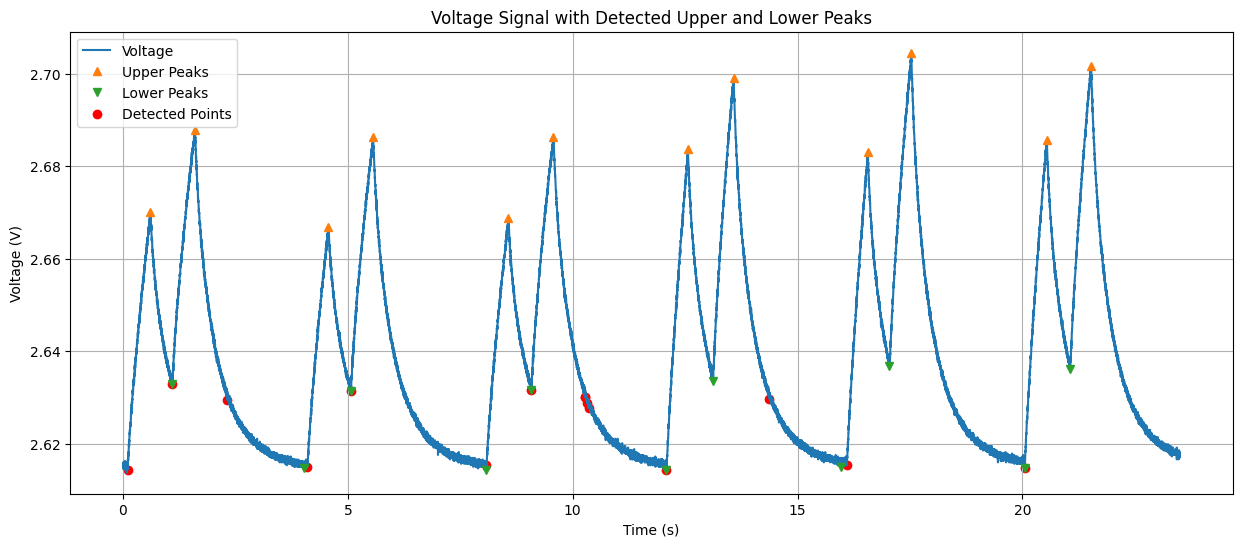

Number of upper peaks detected: 12
Number of lower peaks detected: 11


In [5]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def find_stable_intervals(data, rolling_window=100, threshold=0.001, smoothing_window=5, min_stable_length=10, transition='both'):
    df_first_index = data.index[0]
    bool_series = data.rolling(window=rolling_window).std() < threshold

    smoothed_series = bool_series.rolling(window=smoothing_window, center=True).mean() > 0.5

    # Handle NaN values
    smoothed_series = smoothed_series.fillna(False)

    if transition == 'true_to_false':
        change_indexes = (smoothed_series.shift().astype(bool) & ~smoothed_series.astype(bool)).index[smoothed_series.shift().astype(bool) & ~smoothed_series.astype(bool)]
    elif transition == 'false_to_true':
        change_indexes = (~smoothed_series.shift().astype(bool) & smoothed_series.astype(bool)).index[~smoothed_series.shift().astype(bool) & smoothed_series.astype(bool)]
    else:  # 'both'
        raise ValueError("Invalid transition type")

    filtered_changes = []
    for i in range(len(change_indexes)):
        if i == 0:
            if change_indexes[i] >= min_stable_length:
                filtered_changes.append(change_indexes[i])
        elif i == len(change_indexes) - 1:
            if len(smoothed_series) - change_indexes[i] >= min_stable_length:
                filtered_changes.append(change_indexes[i])
        else:
            if change_indexes[i] - change_indexes[i-1] >= min_stable_length:
                filtered_changes.append(change_indexes[i])

    # print(filtered_changes)
    min_indexes = []
    for idx in filtered_changes:
        start = max(0, idx - 30)
        end = min(len(data) - 1, idx + 31)
        window = data.iloc[start:end]
        # print(start, end, len(window), data.index[0] - df_first_index, data.index[-1] - df_first_index)
        if len(window) == 0:
            continue
        # min_idx = start + window.idxmin() - window.index[0]
        min_idx = window.idxmin() - df_first_index # still bugs here
        min_indexes.append(min_idx)

    return min_indexes


test_file = "20250110 demo 2 good/421R/72_Data.txt"

data = pd.read_csv(test_file, sep=' ', skiprows=1, names=['t', 'V'], index_col=False)
data = data.dropna(axis=1)


upper_peaks, _ = find_peaks(data['V'], distance=100, prominence=0.01)
lower_peaks, _ = find_peaks(-data['V'], distance=100, prominence=0.01)
min_indexes = find_stable_intervals(data['V'], transition='true_to_false')


# Plot original signal and both sets of peaks
plt.figure(figsize=(15, 6))
plt.plot(data['t'], data['V'], label='Voltage')
plt.plot(data['t'][upper_peaks], data['V'][upper_peaks], "^", label='Upper Peaks')
plt.plot(data['t'][lower_peaks], data['V'][lower_peaks], "v", label='Lower Peaks')
plt.scatter(data['t'].loc[min_indexes], data['V'].loc[min_indexes], color='red', marker='o', label='Detected Points')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Signal with Detected Upper and Lower Peaks')
plt.grid(True)
plt.legend()
plt.show()


print(f"Number of upper peaks detected: {len(upper_peaks)}")
print(f"Number of lower peaks detected: {len(lower_peaks)}")


In [6]:
import numpy as np
import os

def extract_features(file_name, use_max_peak='second'):
    data = pd.read_csv(file_name, sep=' ', skiprows=1, names=['t', 'V'], index_col=False)
    data = data.dropna(axis=1)


    upper_peaks, _ = find_peaks(data['V'], distance=100, prominence=0.01)
    lower_peaks, _ = find_peaks(-data['V'], distance=100, prominence=0.01)
    min_indexes = find_stable_intervals(data['V'], transition='true_to_false')

    assert len(upper_peaks) == 12
    n_samples = len(upper_peaks) // 2

    results = []
    for i in range(n_samples):
        first_max_peak = upper_peaks[2*i]
        second_max_peak = upper_peaks[2*i+1]
        min_peaks = [i for i in lower_peaks if i > first_max_peak and i < second_max_peak]
        assert len(min_peaks) == 1
        min_peak = min_peaks[0]
        start_peaks = [i for i in min_indexes if i < first_max_peak]
        assert len(start_peaks) >= 1
        start_peak = max(start_peaks)

        if use_max_peak == 'second':
            results.append(data['V'].iloc[second_max_peak] - data['V'].iloc[start_peak])
        elif use_max_peak == 'first':
            results.append(data['V'].iloc[first_max_peak] - data['V'].iloc[start_peak])
        else:
            raise ValueError("Invalid use_max_peak value")

    first_half = results[:3]
    second_half = results[3:]
    return (np.median(first_half), np.median(second_half))
    # return (np.mean(first_half), np.mean(second_half))


In [4]:
path_420 = "20250110 demo 2 good/420"
path_421 = "20250110 demo 2 good/421"

samples_420 = [extract_features(os.path.join(path_420, i), use_max_peak='second') for i in os.listdir(path_420) if i.endswith("_Data.txt") and i not in []]
samples_421 = [extract_features(os.path.join(path_421, i), use_max_peak='second') for i in os.listdir(path_421) if i.endswith("_Data.txt")]

df_420 = pd.DataFrame(samples_420, columns=['first', 'second'])
df_420['label'] = 0

df_421 = pd.DataFrame(samples_421, columns=['first', 'second']) 
df_421['label'] = 1

combined_df = pd.concat([df_420, df_421], ignore_index=True)
combined_df.to_csv('reservoir_4set_v2.csv', index=False)

In [5]:
path_420_raw = "20250110 demo 2 good/420R"
path_421_raw = "20250110 demo 2 good/421R"

samples_420_raw = [extract_features(os.path.join(path_420_raw, i), use_max_peak='second') for i in os.listdir(path_420_raw) if i.endswith("_Data.txt") and i not in []]
samples_421_raw = [extract_features(os.path.join(path_421_raw, i), use_max_peak='second') for i in os.listdir(path_421_raw) if i.endswith("_Data.txt")]

df_420_raw = pd.DataFrame(samples_420_raw, columns=['first', 'second'])
df_420_raw['label'] = 0

df_421_raw = pd.DataFrame(samples_421_raw, columns=['first', 'second']) 
df_421_raw['label'] = 1

combined_df_raw = pd.concat([df_420_raw, df_421_raw], ignore_index=True)
combined_df_raw.to_csv('reservoir_4setR_v2.csv', index=False)

In [6]:
path_420_raw = "20250110 demo 2 good/420R"
path_421_raw = "20250110 demo 2 good/421R"

samples_420_raw = [extract_features(os.path.join(path_420_raw, i), use_max_peak='first') for i in os.listdir(path_420_raw) if i.endswith("_Data.txt") and i not in []]
samples_421_raw = [extract_features(os.path.join(path_421_raw, i), use_max_peak='first') for i in os.listdir(path_421_raw) if i.endswith("_Data.txt")]

df_420_raw = pd.DataFrame(samples_420_raw, columns=['first', 'second'])
df_420_raw['label'] = 0

df_421_raw = pd.DataFrame(samples_421_raw, columns=['first', 'second']) 
df_421_raw['label'] = 1

combined_df_raw = pd.concat([df_420_raw, df_421_raw], ignore_index=True)
combined_df_raw.to_csv('reservoir_2set_v2.csv', index=False)

In [7]:
# 4-feature extraction
path_420_raw = "20250110 demo 2 good/420R"
path_421_raw = "20250110 demo 2 good/421R"

samples_420_raw = [extract_features(os.path.join(path_420_raw, i), use_max_peak='first') for i in os.listdir(path_420_raw) if i.endswith("_Data.txt") and i not in []]
samples_421_raw = [extract_features(os.path.join(path_421_raw, i), use_max_peak='first') for i in os.listdir(path_421_raw) if i.endswith("_Data.txt")]

df_420_raw = pd.DataFrame(samples_420_raw, columns=['first_raw', 'second_raw'])
df_420_raw['label'] = 0

df_421_raw = pd.DataFrame(samples_421_raw, columns=['first_raw', 'second_raw']) 
df_421_raw['label'] = 1

path_420 = "20250110 demo 2 good/420"
path_421 = "20250110 demo 2 good/421"

samples_420 = [extract_features(os.path.join(path_420, i), use_max_peak='first') for i in os.listdir(path_420) if i.endswith("_Data.txt") and i not in []]
samples_421 = [extract_features(os.path.join(path_421, i), use_max_peak='first') for i in os.listdir(path_421) if i.endswith("_Data.txt")]

df_420 = pd.DataFrame(samples_420, columns=['first', 'second'])
df_420['label'] = 0

df_421 = pd.DataFrame(samples_421, columns=['first', 'second']) 
df_421['label'] = 1

# Combine raw and processed features for 420
df_420_combined = pd.concat([df_420_raw, df_420.drop('label', axis=1)], axis=1)

# Combine raw and processed features for 421
df_421_combined = pd.concat([df_421_raw, df_421.drop('label', axis=1)], axis=1)

# Combine both datasets
combined_df = pd.concat([df_420_combined, df_421_combined], ignore_index=True)
combined_df.to_csv('reservoir_full_4set_v2.csv', index=False)


In [6]:
import os
import numpy as np

def extract_intervals(file_name):
    data = pd.read_csv(file_name, sep=' ', skiprows=1, names=['t', 'V'], index_col=False)
    data = data.dropna(axis=1)


    upper_peaks, _ = find_peaks(data['V'], distance=100, prominence=0.01)
    lower_peaks, _ = find_peaks(-data['V'], distance=100, prominence=0.01)
    min_indexes = find_stable_intervals(data['V'], transition='true_to_false')

    assert len(upper_peaks) == 12
    n_samples = len(upper_peaks) // 2

    results = []
    for i in range(n_samples):
        first_max_peak = upper_peaks[2*i]
        second_max_peak = upper_peaks[2*i+1]
        min_peaks = [i for i in lower_peaks if i > first_max_peak and i < second_max_peak]
        assert len(min_peaks) == 1
        min_peak = min_peaks[0]
        start_peaks = [i for i in min_indexes if i < first_max_peak]
        assert len(start_peaks) >= 1
        start_peak = max(start_peaks)

        
        results.append((data['V'].iloc[second_max_peak] - data['V'].iloc[start_peak], ((data['t'].iloc[start_peak:second_max_peak] - data['t'].iloc[start_peak]).to_list(), 
                       data['V'].iloc[start_peak:second_max_peak].to_list())))

    return results

def process_all_files_intervals(path, save_xlsx_prefix):
    feature1 = []
    feature2 = []
    for file in os.listdir(path):
        if file.endswith("_Data.txt"):
            tmp = extract_intervals(os.path.join(path, file))
            assert len(tmp) == 6
            feature1_median_index = np.argsort([tmp[0][0], tmp[1][0], tmp[2][0]])[1]
            feature2_median_index = np.argsort([tmp[3][0], tmp[4][0], tmp[5][0]])[1] + 3
            feature1.append(tmp[feature1_median_index][1])
            feature2.append(tmp[feature2_median_index][1])

    print(len(feature1), len(feature1[0]))

    # Create list of dataframes for feature1
    dfs1 = []
    for i, (t, v) in enumerate(feature1):
        df = pd.DataFrame({
            f't{i+1}': t,
            f'v{i+1}': v
        })
        dfs1.append(df)
    
    # Concatenate all feature1 dataframes
    df = pd.concat(dfs1, axis=1)
    df.to_excel(f'{save_xlsx_prefix}_feature1.xlsx', index=False)

    # Create list of dataframes for feature2 
    dfs2 = []
    for i, (t, v) in enumerate(feature2):
        df = pd.DataFrame({
            f't{i+1}': t,
            f'v{i+1}': v
        })
        dfs2.append(df)
    
    # Concatenate all feature2 dataframes
    df2 = pd.concat(dfs2, axis=1)
    df2.to_excel(f'{save_xlsx_prefix}_feature2.xlsx', index=False)

path_420 = "20250110 demo 2 good/420"
path_421 = "20250110 demo 2 good/421"
process_all_files_intervals(path_420, "420_4set")
process_all_files_intervals(path_421, "421_4set")


126 2
78 2
